In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import copy
import random
import json
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
#sns.set_theme(style="ticks", palette="pastel")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [4]:
from resources.helper import PeakData, Isotopes
known_cys_fnam = 'resources/known_cys_labeled.tab'
known_gln_fnam = 'resources/known_gln_labeled.tab'
# blacklist_fnam = 'resources/blacklist.tab'
blacklist_fnam = 'resources/blacklist-GSH-artifacts.tab'

# Read isotope information into an object:
IUPAC_atomic_masses = 'resources/IUPAC-atomic-masses.csv'
IUPAC_atomic_abundances = 'resources/IUPAC-atomic-abundances.html'
isotope_obj = Isotopes(IUPAC_atomic_masses, IUPAC_atomic_abundances)

# Adducts:
adducts_fnam = 'resources/adducts.tab'

## Define default parameters for peak filtering and peak pair finding

In [5]:
params = {
    ### Specify the formula for the isotopes in the labels used ###
    'labels': {
        'cys': '[13]C3 [15]N',
        'gly': '[13]C2',
        'gln': '[13]C5'
    },
    # End of isotope specification ################################

    ### Peak filter parameters ###
    'min_area': 25000,        # minimum peak area for at least one sample
    'min_area_label': 15000,  # minimum peak area for at least one labelled sample
    'min_MW': 120,            # minimum molecular weight of a compound (120 is one Da below Cysteine)
    'min_fold_blank': 4,      # minimum sample to blank peak area ratio
                              # i.e. max(sample)/max(blank) > min_fold_blank

    # Peak filter: peak merging #
    # Merge peaks within a ppm mass distance AND within
    # a retention time difference OR a retention time difference x2
    # AND over a minimum peak area correlation coefficient
    'merge_ppm_tol': 50,      # maximum mass distance (in ppm) between peaks to merge
    'merge_RT_tol': 0.1,      # maximum retention time difference between peaks to merge
    'merge_corr_tol':0.9,     # minimum peak area correlation coefficient
    # End of peak filter #########
    
    ### Peak pair finding ###
    'pair_ppm_tol': 10,            # maximum mass distance (in ppm) of expected mass shift between pairs
    'pair_RT_tol': 0.25,           # maximum retention time difference between pairs
    'pair_min_area': 1,            # minimum number of sample that pass the area ratio criterium

    # Range, or list of ranges, of labelled to unlabelled peak area ratios
    # within the accepted cutoff (ratio = labelled / sum(labelled, unlabelled))
    # These ratios are adjusted on an experiment-to-experiment basis (see below examples).
    'area_ratio_cutoff': {
        'cys': ((0.2, 0.28),
                (0.34, 0.42)),  # GSSG theoretical parent/(parent+heavy) is 0.25 with 50/50 labelled
        'gly': ((0.08, 0.24),),
        'gln': ((0.18, 0.6),),
    },
    # End of pair finding ###
    
    ### Peak pair filter parameters ###
    # Pair filter: adduct flagging #
    # Flag an adduct if it is within a ppm mass distance
    # and within a retention time difference
    # and has smaller total peak area than its parent ion
    'adduct_ppm_tol': 200,     # maximum mass distance (in ppm) to call adduct
    'adduct_RT_tol': 0.8,      # maximum retention time difference to call adduct

    # Pair filter: isotope flagging #
    # Flag an isotope if it is within a ppm mass distance
    # and within a retention time difference
    # and has a minimum peak area correlation coefficient
    # and has smaller total peak area than its parent ion
    'isotope_ppm_tol': 200,     # maximum mass distance (in ppm) to call isotope
    'isotope_RT_tol': 0.4,      # maximum retention time difference to call isotope
    'isotope_corr_tol':0.7,     # minimum peak area correlation coefficient to call isotope
    # End of peak pair filter #########

}

# Calculate the mass shift for each label:
params['MW_shift'] = dict()
for label in params['labels']:
    params['MW_shift'][label] = isotope_obj.isotopes2mass_shift(params['labels'][label])
print('Calculated mass shift for entered labels:')
pp.pprint(params['MW_shift'])

Calculated mass shift for entered labels:
{'cys': 4.007099400040005,
 'gln': 5.016774176699997,
 'gly': 2.0067096706799994}


## Cysteine tracing on NRF2 on/off cancer cell lines

Anna.

Put description here.


In [6]:
# Excel data filenames:
datafile_pos = 'projects/bile-duct-cells_cys-tracing/pos/bile-duct-cells_cys-tracing_pos.xlsx'
datafile_neg = 'projects/bile-duct-cells_cys-tracing/neg/bile-duct-cells_cys-tracing_neg.xlsx'

# Input information:
input_desc_fnam = 'projects/bile-duct-cells_cys-tracing/bile-duct-cells_cys-tracing.json'
# Since comments are not allowed in JSON format
# Use the eval function to turn this pseudo JSON into a dictionary:
input_desc = eval(open(input_desc_fnam, 'r').read())

# Read the data:
peak_obj = PeakData('bile-duct-cells_cys-tracing', input_desc, params)

# Read peaks:
peak_obj.read_peaks(datafile_pos, 'pos')
peak_obj.read_peaks(datafile_neg, 'neg')

# Annotate known peaks:
peak_obj.annotate_known_peaks(known_cys_fnam, isotope_obj.formula2mass)

Running peak filtering for polarity: pos
Filtered 30135 peaks out based on.
Minimum peak area: 26150
Minimum molecular weight: 1581
Minimum fold over blank: 1696
Merged closely related peaks: 708
6161 peaks left.

Running peak filtering for polarity: neg
Filtered 15821 peaks out based on.
Minimum peak area: 13745
Minimum molecular weight: 861
Minimum fold over blank: 850
Merged closely related peaks: 365
3757 peaks left.



### Adjust parameters for peak pair finding

In [7]:
# Find labelling ratio for known cysteine labelled
# compounds in positive polarity:
peak_obj.pick_ratio(known_cys_fnam, 'pos', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),G3P Cys (m),G3P Cys (m+4),DHAP Cys (m),DHAP Cys (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4)
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,0.712050,0.287950,0.677556,0.322444,0.677556,0.322444,0.730873,0.269127
std,0.034968,0.034968,0.062214,0.062214,0.062214,0.062214,0.043872,0.043872
min,0.653303,0.219903,0.489956,0.177083,0.489956,0.177083,0.665076,0.166248
25%,0.681747,0.259490,0.659421,0.287833,0.659421,0.287833,0.692165,0.244489
50%,0.714325,0.285675,0.682375,0.317625,0.682375,0.317625,0.728221,0.271779
75%,0.740510,0.318253,0.712167,0.340579,0.712167,0.340579,0.755511,0.307835
max,0.780097,0.346697,0.822917,0.510044,0.822917,0.510044,0.833752,0.334924


In [8]:
# Find labelling ratio for known cysteine labelled
# compounds in negative polarity:
peak_obj.pick_ratio(known_cys_fnam, 'neg', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),GSSG (m),GSSG (m+4),S-Lactoylglutathione (m),S-Lactoylglutathione (m+4),G3P Cys (m),G3P Cys (m+4),DHAP Cys (m),DHAP Cys (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4)
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,0.811704,0.188296,0.601184,0.398816,0.673176,0.326824,0.595374,0.404626,0.595374,0.404626,0.736890,0.263110
std,0.040624,0.040624,0.091970,0.091970,0.271515,0.271515,0.179065,0.179065,0.179065,0.179065,0.055895,0.055895
min,0.695934,0.112465,0.421315,0.141711,0.158550,0.011648,0.135472,0.037268,0.135472,0.037268,0.622300,0.170606
25%,0.794570,0.159100,0.541626,0.365109,0.408236,0.049883,0.547555,0.307316,0.547555,0.307316,0.686496,0.227070
50%,0.820300,0.179700,0.586749,0.413251,0.763015,0.236985,0.644210,0.355790,0.644210,0.355790,0.743820,0.256180
75%,0.840900,0.205430,0.634891,0.458374,0.950117,0.591764,0.692684,0.452445,0.692684,0.452445,0.772930,0.313504
max,0.887535,0.304066,0.858289,0.578685,0.988352,0.841450,0.962732,0.864528,0.962732,0.864528,0.829394,0.377700


In [9]:
# Based on above analysis the cutoff is chosen:
peak_obj.params['area_ratio_cutoff']['cys'] = ((0.05, 0.90),)

# RT and MW tolerances are also adjusted:
peak_obj.params['pair_ppm_tol'] = 5
peak_obj.params['pair_RT_tol'] = 0.25

### Search for peak pairs and flag isotopes, adducts etc

In [10]:
# Find pairs:
peak_obj.find_pairs('pos')
peak_obj.find_pairs('neg')

In [11]:
# Flag inferred adducts and blacklisted compounds
# in the peak pairs:
peak_obj.flag_blacklist(blacklist_fnam, polarity='both')
peak_obj.flag_adducts(adducts_fnam, polarity='both')

In [12]:
# Generate isotopic mass shift combinations:
isotope_set = isotope_obj.find_iso_set(min_abs=1e-6)
pp.pprint(isotope_set)

{('[13]C',): {'abundance': 0.010599999999999998,
              'mass_shift': 1.0033548353399997},
 ('[13]C', '[13]C'): {'abundance': 0.00011235999999999996,
                      'mass_shift': 2.0067096706799994},
 ('[13]C', '[13]C', '[13]C'): {'abundance': 1.1910159999999995e-06,
                               'mass_shift': 3.010064506020001},
 ('[13]C', '[13]C', '[34]S'): {'abundance': 4.9045139999999985e-06,
                               'mass_shift': 4.002505508140004},
 ('[13]C', '[15]N'): {'abundance': 4.022699999999999e-05,
                      'mass_shift': 2.0003897293599984},
 ('[13]C', '[15]N', '[34]S'): {'abundance': 1.7559085499999997e-06,
                               'mass_shift': 3.996185566820003},
 ('[13]C', '[17]O'): {'abundance': 4.065099999999999e-06,
                      'mass_shift': 2.00757197203},
 ('[13]C', '[18]O'): {'abundance': 2.1676999999999996e-05,
                      'mass_shift': 3.007599828220002},
 ('[13]C', '[2]H'): {'abundance': 1.53699999999

In [13]:
# Flag isotopes in the peak pairs:
peak_obj.flag_isotopes(isotope_set, polarity='both')

In [14]:
# Write results as Excel files:
peak_obj.write_pairs('projects/bile-duct-cells_cys-tracing/pos/bile-duct-cells_cys-tracing_pairs_pos', 'pos')
peak_obj.write_pairs('projects/bile-duct-cells_cys-tracing/neg/bile-duct-cells_cys-tracing_pairs_neg', 'neg')

### Processing the results

At this point, all the results have been written to Excel files which provide an interface to further processing/filtering/plotting.

In the following, I will show another way of processing the results and show some of the findings that can be extracted from the data.

In [15]:
# Extract sample information from the input description JSON
# stored in the "group" tag:
name2info = {desc['name']: desc for desc in input_desc.values() if desc['type'] != 'blank'}
sample_info_df = pd.DataFrame.from_dict(name2info, orient='index')
sample_info_df[['Cell_line','Genotype']] = sample_info_df.group.str.split(', ', expand=True)
sample_info_df.head(4)

,name,order,type,label,group,Cell_line,Genotype
CCLP_1,CCLP_1,19,sample,cys,"CCLP, bile-duct-NRF2-off",CCLP,bile-duct-NRF2-off
CCLP_2,CCLP_2,20,sample,cys,"CCLP, bile-duct-NRF2-off",CCLP,bile-duct-NRF2-off
CCLP_3,CCLP_3,21,sample,cys,"CCLP, bile-duct-NRF2-off",CCLP,bile-duct-NRF2-off
SSP25_1,SSP25_1,7,sample,cys,"SSP25, bile-duct-NRF2-on",SSP25,bile-duct-NRF2-on


In [16]:
# We start in positive polarity by grabbing the peak pairs from cystine tracing:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
df_pos.head(4)

,pair_id,MW_parent,RT_parent,MW_heavy,RT_heavy,polarity,label,name,RT_diff,MW_ppm_diff,Isotopes,Adducts,Blacklist,known_anno,KKU100_1,KKU100_2,KKU100_3,SNU308_1,SNU308_2,SNU308_3,SSP25_1,SSP25_2,SSP25_3,TFK_1,TFK_2,...,SSP25_13C-Glc_6h_3,SSP25_13C-Glc_24h_1,SSP25_13C-Glc_24h_2,SSP25_13C-Glc_24h_3,SSP25_Vec-013023_1,SSP25_Vec-013023_2,SSP25_Vec-013023_3,SSP25_DMF_1,SSP25_DMF_2,SSP25_DMF_3,SSP25_Low-Cys_1,SSP25_Low-Cys_2,SSP25_Low-Cys_3,SSP25_Glu_1,SSP25_Glu_2,SSP25_Glu_3,SSP25_Erastin_1,SSP25_Erastin_2,SSP25_Erastin_3,SSP25_Vec-031523_1,SSP25_Vec-031523_2,SSP25_Vec-031523_3,SSP25_BSO_1,SSP25_BSO_2,SSP25_BSO_3
0,"((121.01976, 8.666), (125.02687, 8.682), pos, ...",121.01976,8.666,125.02687,8.682,pos,cys,Cysteine,0.016,0.087589,None,None,None,Cysteine,128705.191879,143663.066097,136363.344539,28927.791413,24499.008772,24619.185302,274401.452337,204811.553192,308980.073615,146139.965726,139139.697031,...,4265.293863,4395.369857,4030.144857,4605.676191,10209.880416,10908.87887,12245.553653,20021.017364,10060.686799,12126.48903,11218.885938,3605.953551,11973.194828,10218.757303,8462.952013,9339.984297,9463.597974,10183.961174,9448.161108,6874.126924,6859.751169,7617.433408,8835.881005,7739.99121,7247.732064
1,"((127.07458, 9.657), (131.08174, 9.599), pos, ...",127.07458,9.657,131.08174,9.599,pos,cys,NaN,0.058,0.476885,None,None,None,None,56158.173814,109244.801144,63997.388557,126500.50263,85696.218444,75916.744305,95799.188795,129949.514898,117431.573592,115839.332096,168732.27178,...,14695.846269,17680.811624,13978.341605,13827.839194,20413.095658,19753.769578,16160.86305,16113.779253,21125.292099,14282.358446,24773.480577,39739.974367,25239.927109,24914.197369,27540.633255,15775.498382,24862.051934,17362.11233,31303.042171,5072934.940766,5136647.669236,5316757.093295,6044596.737377,5749622.97525,5570362.591775
2,"((128.0586, 9.676), (132.06581, 9.56), pos, cys)",128.0586,9.676,132.06581,9.56,pos,cys,Dihydrothymine,0.116,0.863667,None,None,None,None,743038.813262,975966.024274,1050428.096661,6259992.010907,6158803.656498,6722165.02968,954071.735248,905778.69968,1105072.817211,13903431.515933,12718146.881575,...,1874330.336322,5230900.656518,5336689.244431,5159607.817436,2459337.970484,2470846.893196,2326098.993717,2280084.622504,2480010.108148,2463158.54471,2350432.244927,2549288.922352,2394439.701497,1411328.831867,1303000.263125,1520947.629941,2516121.708367,2390887.826845,2550781.72308,5064355.74752,6123165.046293,5480638.974684,7049402.387322,6280530.349428,5647172.016022
3,"((129.0495, 9.802), (133.05679, 10.016), pos, ...",129.0495,9.802,133.05679,10.016,pos,cys,NaN,0.214,1.476952,None,None,None,None,4306.758145,6732.969866,7238.393411,11359.030055,10957.185813,13044.099337,12294.893217,10610.520844,15041.009921,6457.66655,15045.051566,...,7805.269959,29977.53279,58055.526441,25985.679522,22207.099287,57015.760385,45934.341922,20436.579938,9016.125487,8165.235006,30423.948269,61752.128683,41111.11634,20434.891746,48756.313476,23405.206068,57160.66853,55620.195708,104692.530333,20158.966803,33134.465882,22055.692937,22272.346522,18496.884088,38125.080111


In [17]:
def flat_df(df_pol, sample_info_df):
    # Now let's get rid of the adducts, isotopes and blacklisted peaks:
    mask = (df_pol['Isotopes'].isnull() & df_pol['Adducts'].isnull() & df_pol['Blacklist'].isnull()) | ~df_pol['known_anno'].isnull()
    df_pol = df_pol[mask]
    # And flatten the data for easy sorting/filtering/plotting:
    val_list = [cn for cn in df_pol.columns if cn in name2info]    
    df_pol_flat = pd.melt(df_pol, id_vars=['MW_parent', 'RT_parent', 'Adducts', 'known_anno', 'label'], value_vars=val_list, var_name='sample', value_name='area')
    # Add MW_RT string:
    df_pol_flat['MW_RT_anno'] = [str(mw)+'_'+str(rt)+'_'+str(anno) for mw, rt, anno in zip(df_pol_flat['MW_parent'].values, df_pol_flat['RT_parent'].values, df_pol_flat['known_anno'].values)]
    # Add sample info:
    df_pol_flat = df_pol_flat.merge(sample_info_df.loc[:, ['name', 'Cell_line', 'Genotype']], left_on='sample', right_on='name')
    # Drop unnecessary columns:
    df_pol_flat = df_pol_flat.drop(['name'], axis=1)

    return(df_pol, df_pol_flat)

df_pos, df_pos_flat = flat_df(df_pos, sample_info_df)
df_pos_flat.head(3)

,MW_parent,RT_parent,Adducts,known_anno,label,sample,area,MW_RT_anno,Cell_line,Genotype
0,121.01976,8.666,None,Cysteine,cys,KKU100_1,128705.191879,121.01976_8.666_Cysteine,KKU100,bile-duct-NRF2-on
1,127.07458,9.657,None,None,cys,KKU100_1,56158.173814,127.07458_9.657_None,KKU100,bile-duct-NRF2-on
2,128.0586,9.676,None,None,cys,KKU100_1,743038.813262,128.0586_9.676_None,KKU100,bile-duct-NRF2-on


In [18]:
### Get plotting data in positive polarity ###
# Data, no label:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
mask = (df_pos['Isotopes'].isnull() & df_pos['Adducts'].isnull() & df_pos['Blacklist'].isnull()) | ~df_pos['known_anno'].isnull()
df_pos, df_pos_flat = flat_df(df_pos[mask], sample_info_df)

# Data, cysteine label (m+4):
df_pos_m4 = peak_obj.label_pairs['cys']['pos']['peak_pair_area_heavy'].copy()
mask = (df_pos_m4['Isotopes'].isnull() & df_pos_m4['Adducts'].isnull() & df_pos_m4['Blacklist'].isnull()) | ~df_pos_m4['known_anno'].isnull()
df_pos_m4, df_pos_flat_m4 = flat_df(df_pos_m4[mask], sample_info_df)

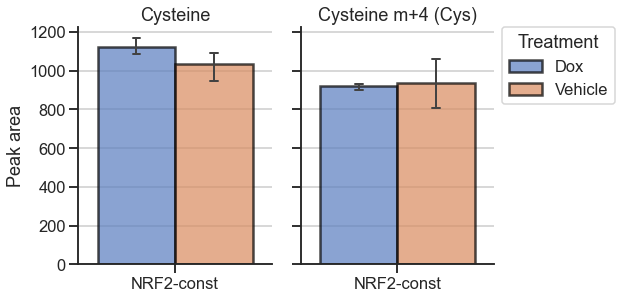

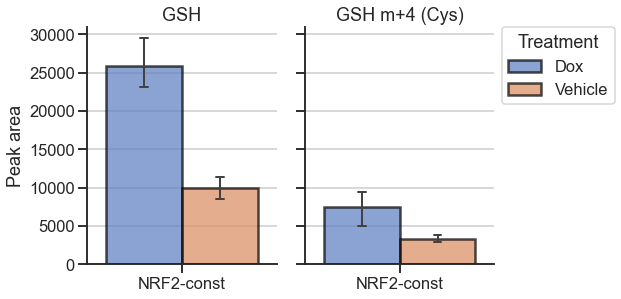

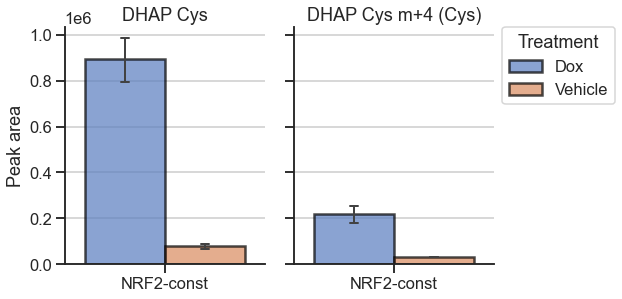

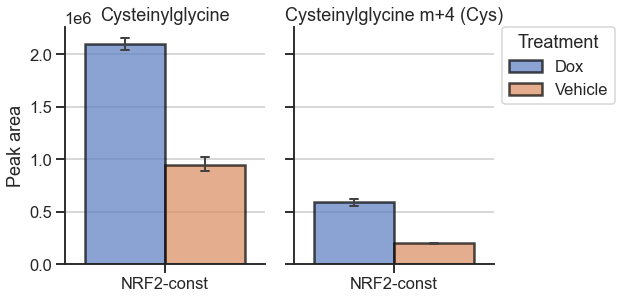

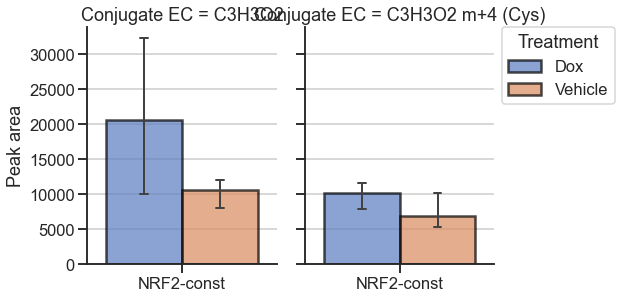

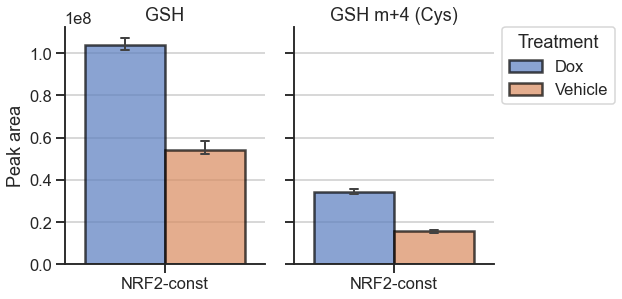

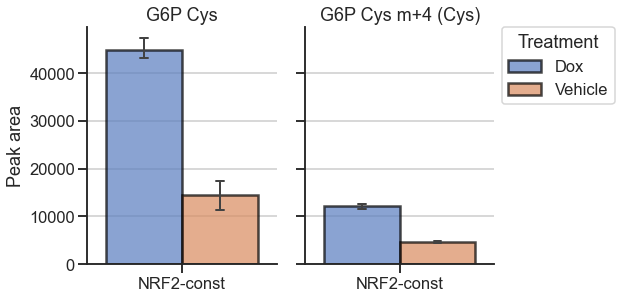

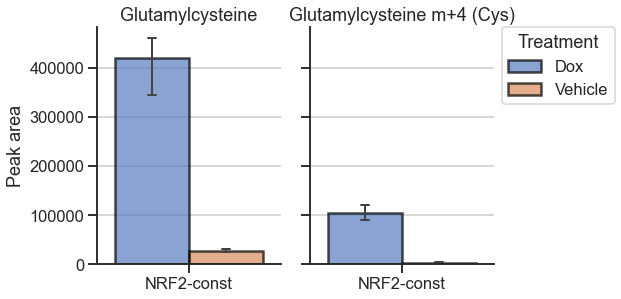

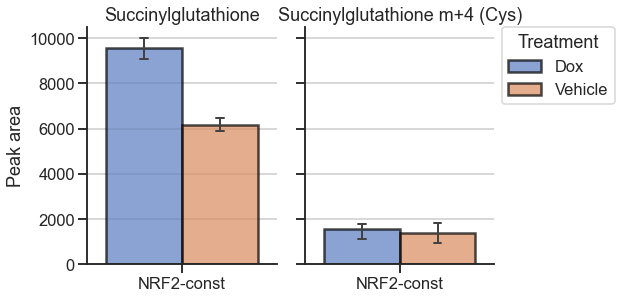

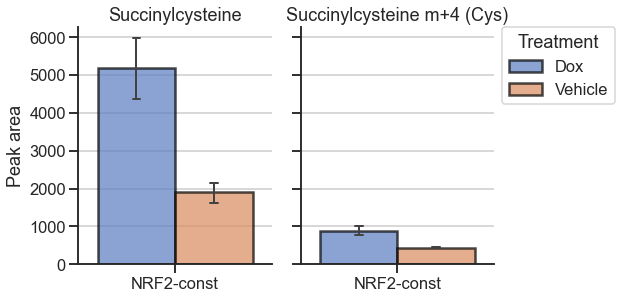

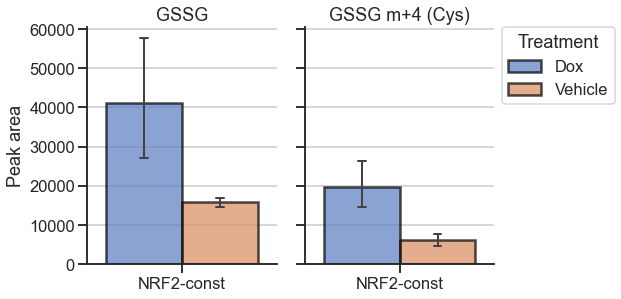

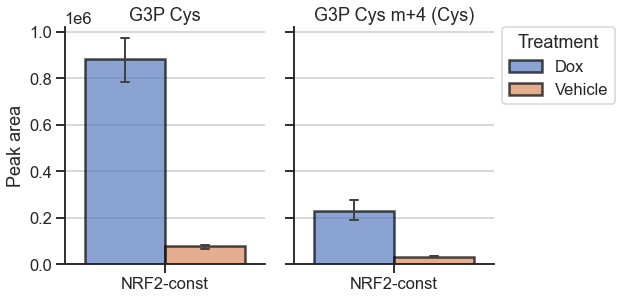

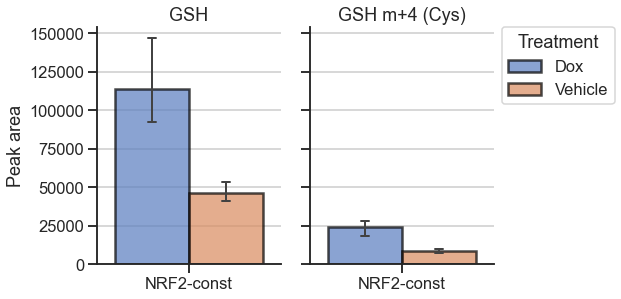

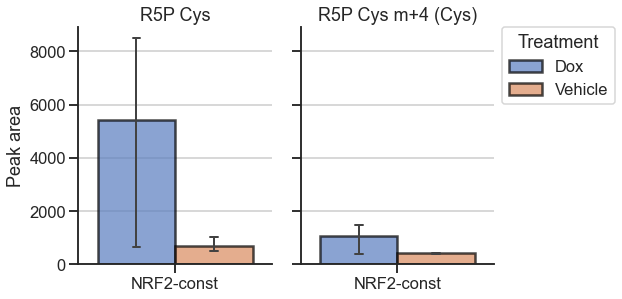

In [19]:
# Plotting, H1299 NRF2 constitutive (positive polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/pos/plots/H1299-NRF2-constitutive'
exclusion_set = {'307.08318_9.584_GSH', '307.08367_11.123_GSH', '307.08367_11.856_GSH', '178.04111_6.946_Cysteinylglycine', '178.04115_9.925_Cysteinylglycine'}
for peak_id in set(df_pos_flat[~df_pos_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)

    ### No label:
    mask = (df_pos_flat['MW_RT_anno'] == peak_id) & (df_pos_flat['Cell_line'] == 'NRF2-const')
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Cell_line', hue='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name)
    g1.grid(True, axis='y')
    g1.legend_.remove()

    ### Cysteine label (m+4):
    mask = (df_pos_flat_m4['MW_RT_anno'] == peak_id) & (df_pos_flat_m4['Cell_line'] == 'NRF2-const')
    g2 = sns.barplot(ax=ax2, data=df_pos_flat_m4[mask], y='area', x='Cell_line', hue='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name))
    g2.grid(True, axis='y')
    g2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Treatment', loc='upper left')
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_NRF2-const.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

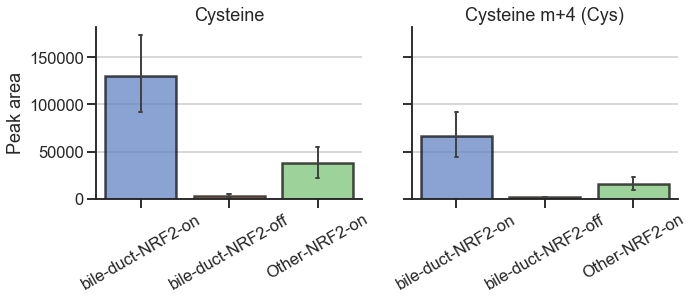

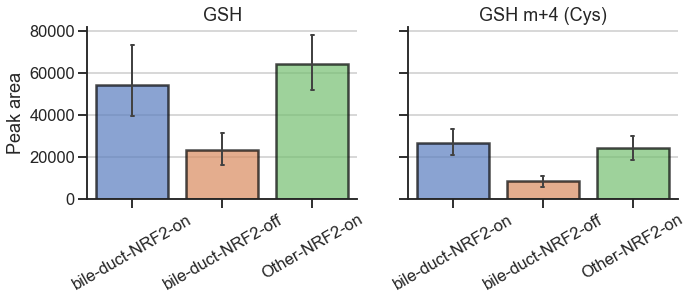

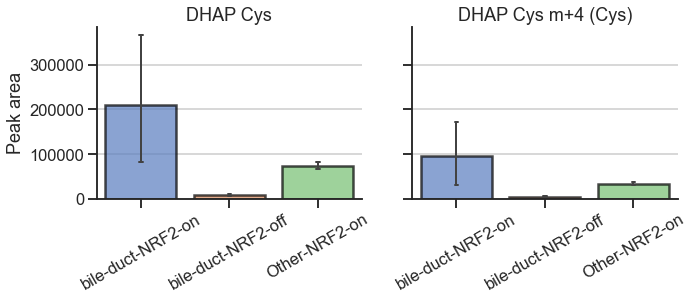

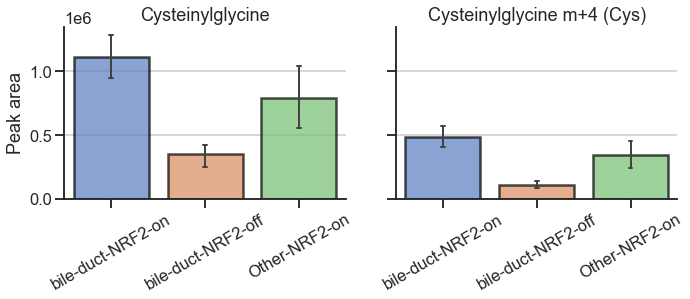

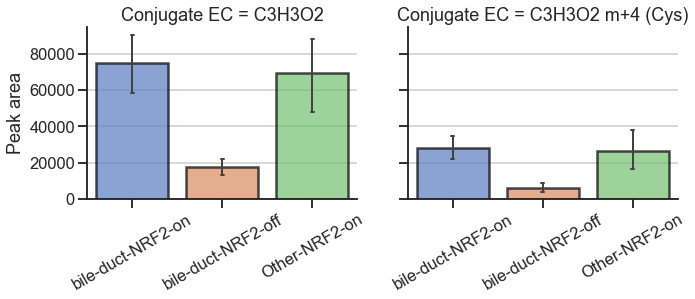

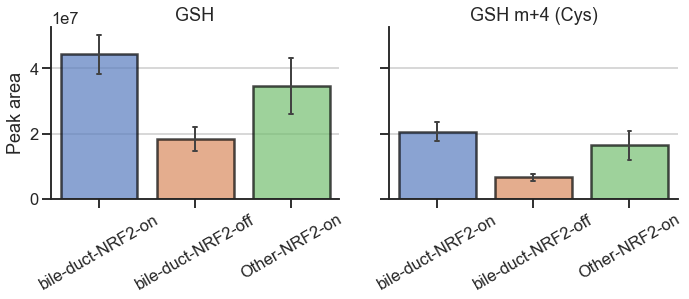

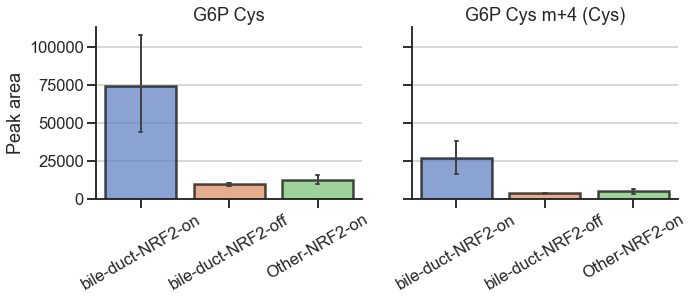

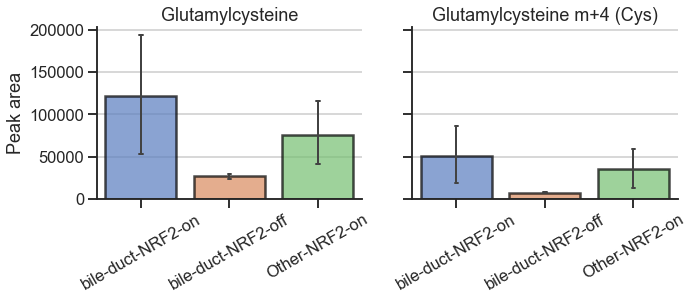

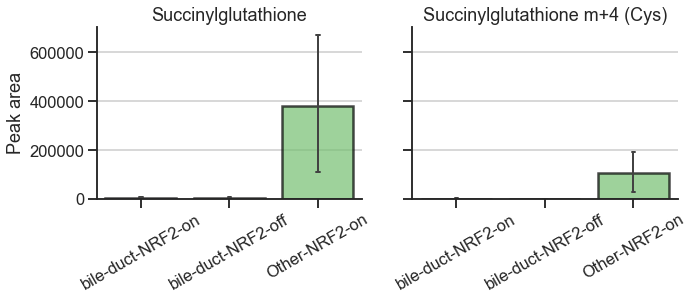

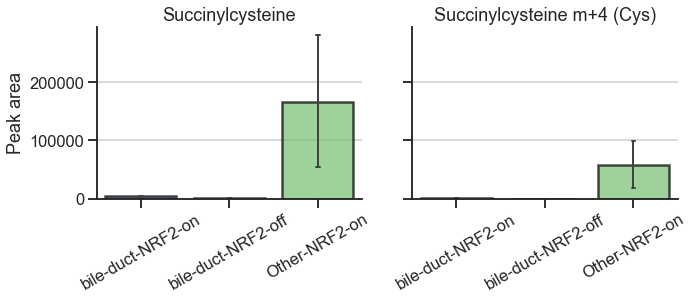

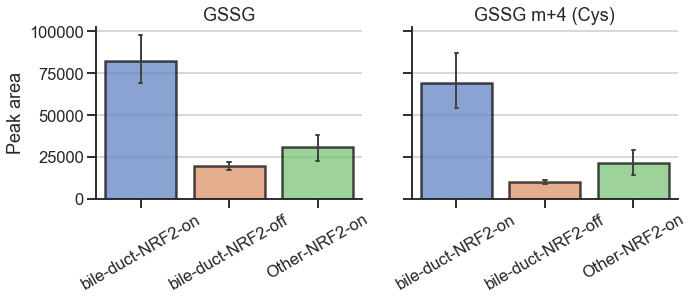

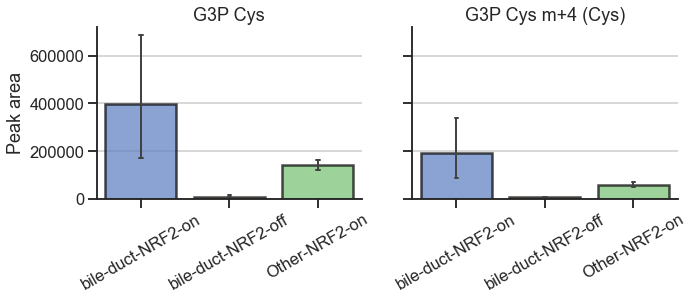

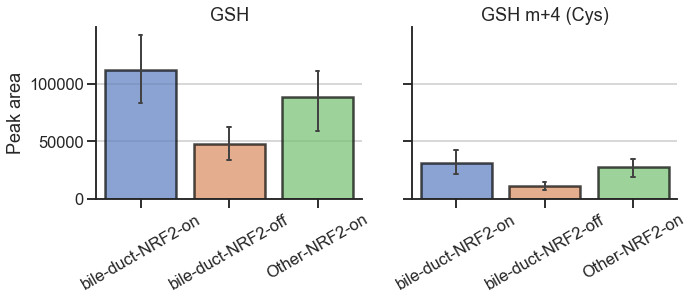

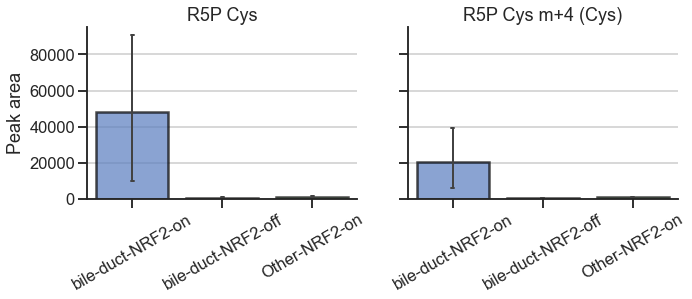

In [20]:
# Plotting, bile duct cells comparison (positive polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/pos/plots/bile-duct-comparison'
exclusion_set = {'307.08318_9.584_GSH', '307.08367_11.123_GSH', '307.08367_11.856_GSH', '178.04111_6.946_Cysteinylglycine', '178.04115_9.925_Cysteinylglycine'}
for peak_id in set(df_pos_flat[~df_pos_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)
    
    ### No label:
    mask = (df_pos_flat['MW_RT_anno'] == peak_id) & (df_pos_flat['Cell_line'] != 'NRF2-const') & ((df_pos_flat['Genotype'] == 'bile-duct-NRF2-on') | (df_pos_flat['Genotype'] == 'bile-duct-NRF2-off') | (df_pos_flat['Genotype'] == 'Other-NRF2-on'))
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)

    ### Cysteine label (m+4):
    mask = (df_pos_flat_m4['MW_RT_anno'] == peak_id) & (df_pos_flat_m4['Cell_line'] != 'NRF2-const') & ((df_pos_flat_m4['Genotype'] == 'bile-duct-NRF2-on') | (df_pos_flat_m4['Genotype'] == 'bile-duct-NRF2-off') | (df_pos_flat_m4['Genotype'] == 'Other-NRF2-on'))
    g2 = sns.barplot(ax=ax2, data=df_pos_flat_m4[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name))
    g2.grid(True, axis='y')
    g2.set_xticklabels(g2.get_xticklabels(), rotation=30)
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

In [21]:
### Get plotting data in negative polarity ###
# Data, no label:
df_neg = peak_obj.label_pairs['cys']['neg']['peak_pair_area_parent'].copy()
mask = (df_neg['Isotopes'].isnull() & df_neg['Adducts'].isnull() & df_neg['Blacklist'].isnull()) | ~df_neg['known_anno'].isnull()
df_neg, df_neg_flat = flat_df(df_neg[mask], sample_info_df)

# Data, cysteine label (m+4):
df_neg_m4 = peak_obj.label_pairs['cys']['neg']['peak_pair_area_heavy'].copy()
mask = (df_neg_m4['Isotopes'].isnull() & df_neg_m4['Adducts'].isnull() & df_neg_m4['Blacklist'].isnull()) | ~df_neg_m4['known_anno'].isnull()
df_neg_m4, df_neg_flat_m4 = flat_df(df_neg_m4[mask], sample_info_df)

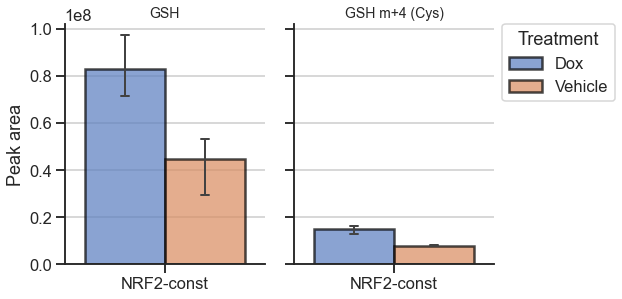

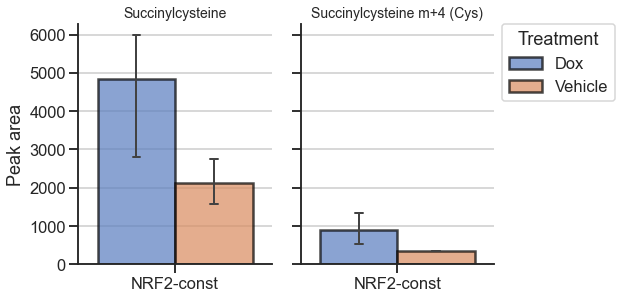

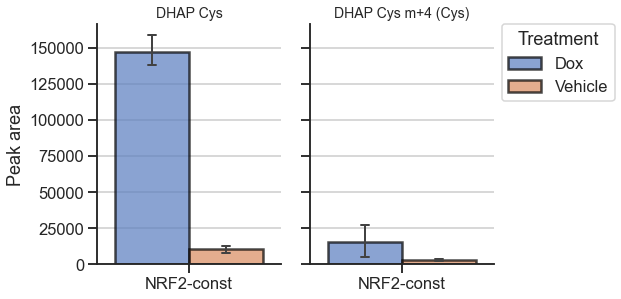

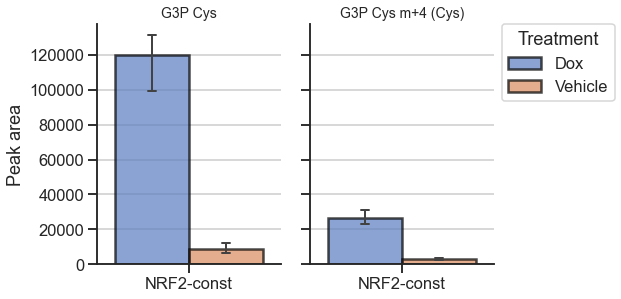

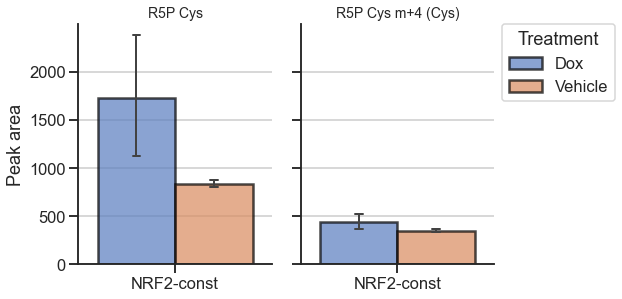

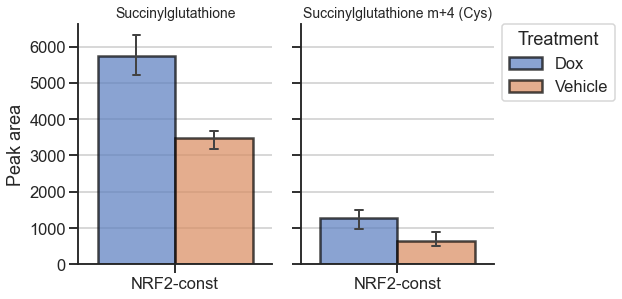

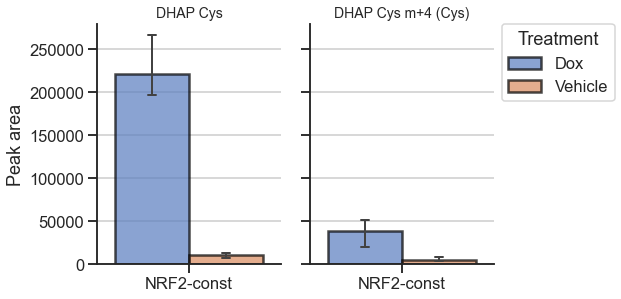

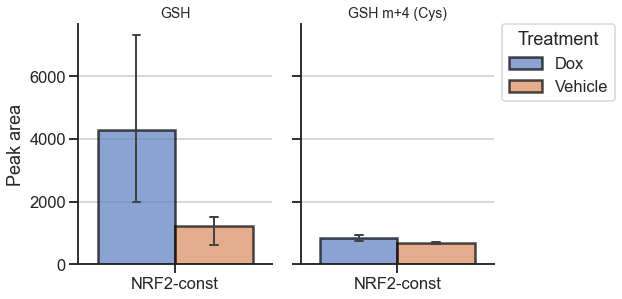

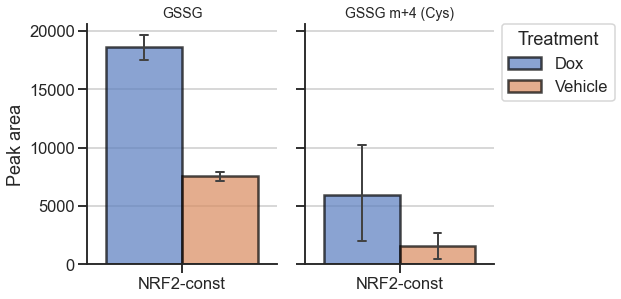

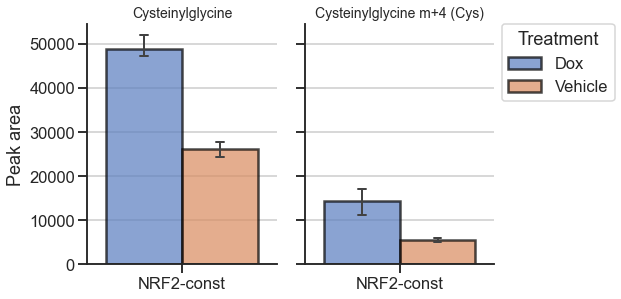

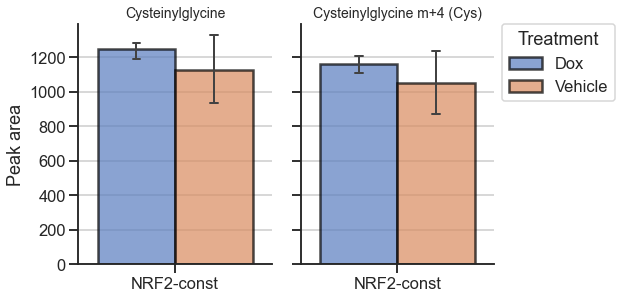

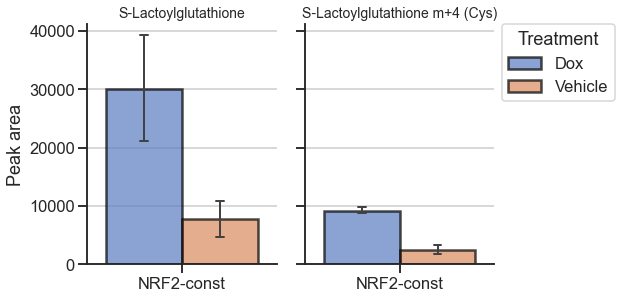

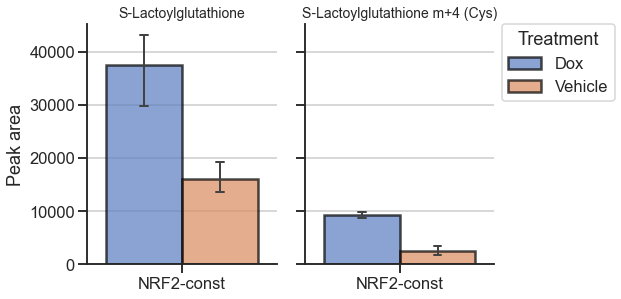

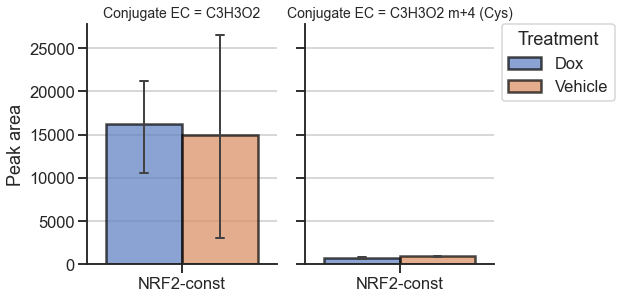

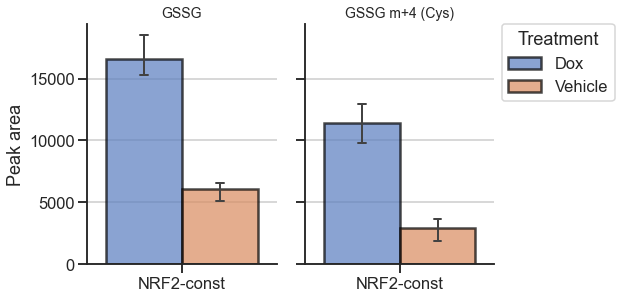

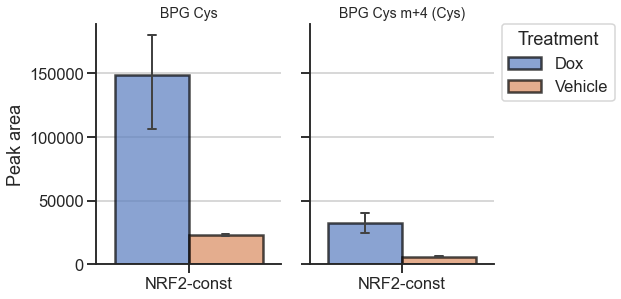

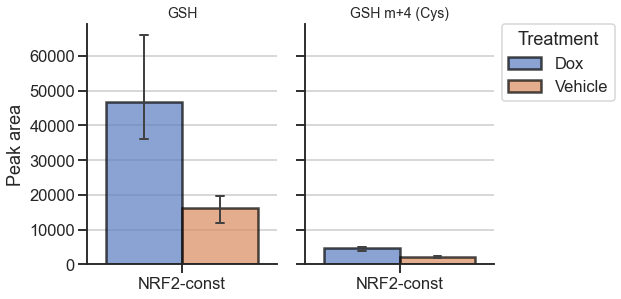

In [22]:
# Plotting, H1299 NRF2 constitutive (negative polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/neg/plots/H1299-NRF2-constitutive'
exclusion_set = {'307.08351_12.044_GSH', '307.08361_10.781_GSH', '307.0835_11.202_GSH', '307.08342_11.437_GSH', '307.08351_8.896_GSH', '307.08328_11.055_GSH', '307.08349_11.838_GSH', '307.08357_11.737_GSH', '307.08357_11.608_GSH', '307.08358_8.71_GSH', '616.15884_11.842_GSSG', '612.15131_12.119_GSSG', '178.04106_7.01_Cysteinylglycine', '178.04108_9.897_Cysteinylglycine', '612.1518_11.807_GSSG', '250.06206_9.745_Glutamylcysteine', '191.0251_10.351_Conjugate EC = C3H3O2'}
for peak_id in set(df_neg_flat[~df_neg_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)

    ### No label:
    mask = (df_neg_flat['MW_RT_anno'] == peak_id) & (df_neg_flat['Cell_line'] == 'NRF2-const')
    g1 = sns.barplot(ax=ax1, data=df_neg_flat[mask], y='area', x='Cell_line', hue='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.legend_.remove()

    ### Cysteine label (m+4):
    mask = (df_neg_flat_m4['MW_RT_anno'] == peak_id) & (df_neg_flat_m4['Cell_line'] == 'NRF2-const')
    g2 = sns.barplot(ax=ax2, data=df_neg_flat_m4[mask], y='area', x='Cell_line', hue='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name), size=14)
    g2.grid(True, axis='y')
    g2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Treatment', loc='upper left')
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_NRF2-const.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

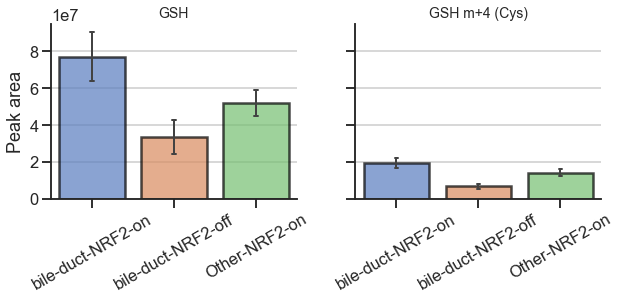

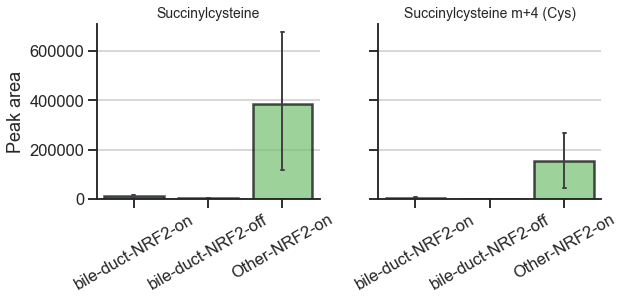

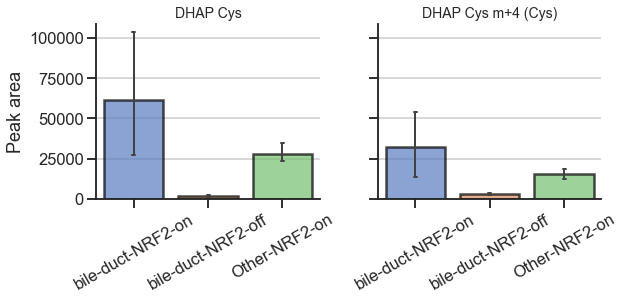

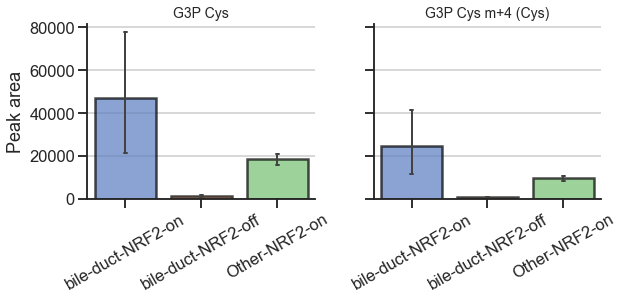

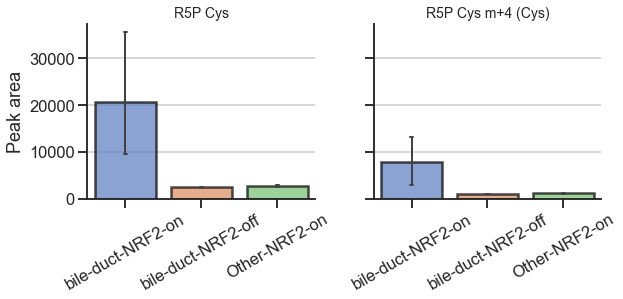

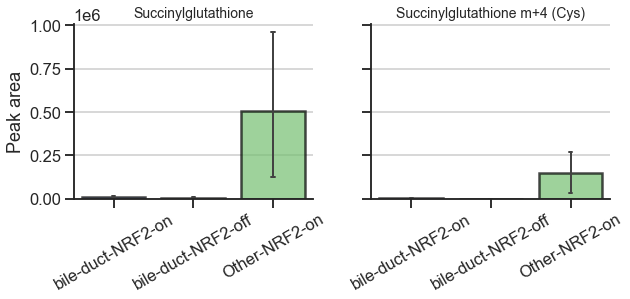

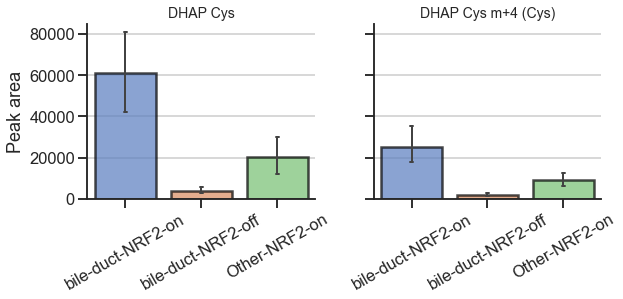

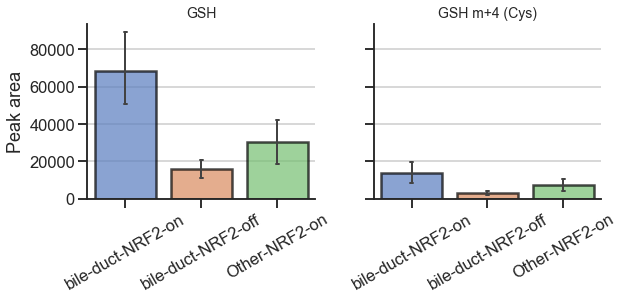

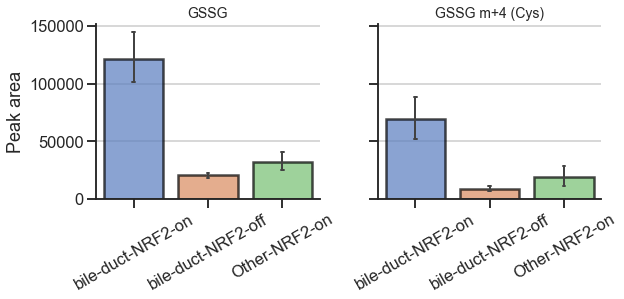

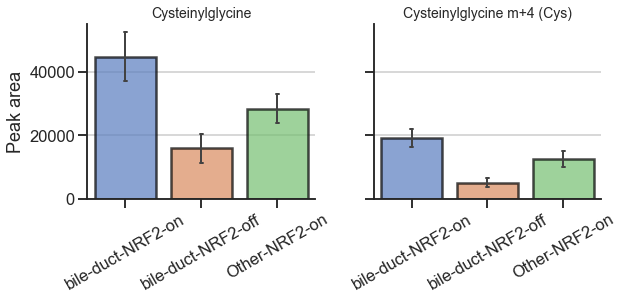

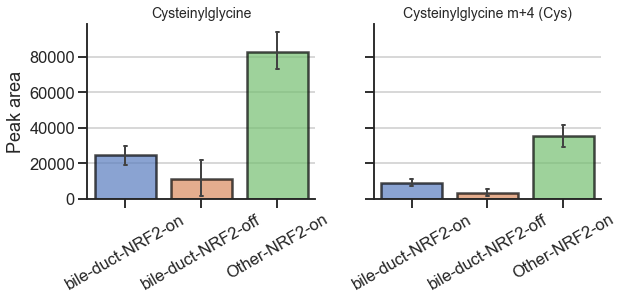

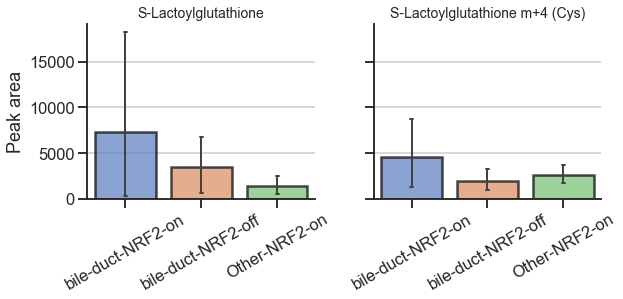

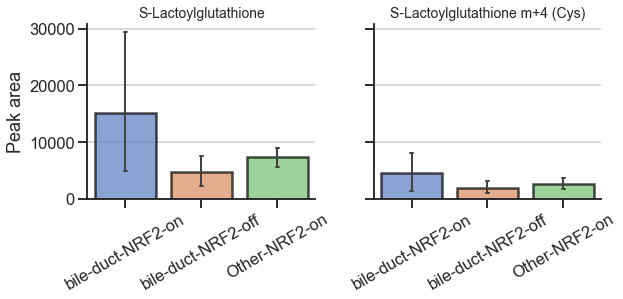

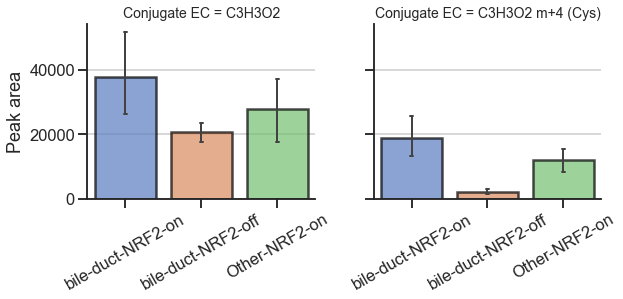

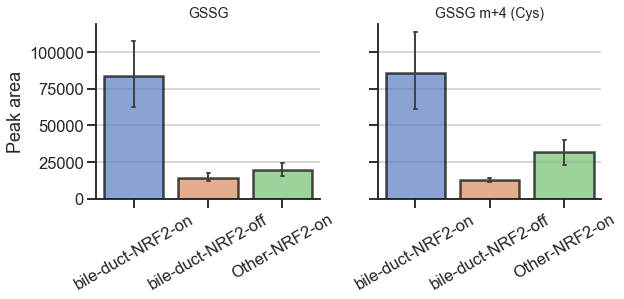

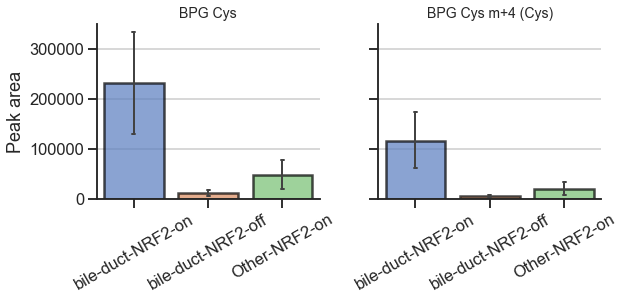

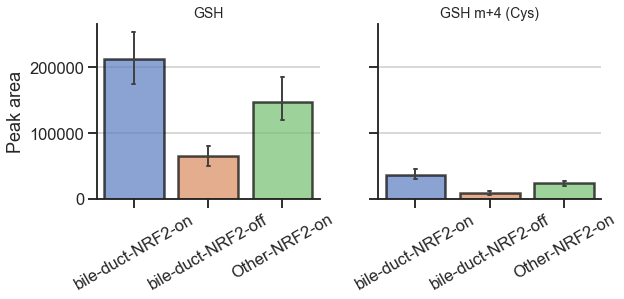

In [23]:
# Plotting, bile duct cells comparison (negative polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/neg/plots/bile-duct-comparison'
exclusion_set = {'307.08351_12.044_GSH', '307.08361_10.781_GSH', '307.0835_11.202_GSH', '307.08342_11.437_GSH', '307.08351_8.896_GSH', '307.08328_11.055_GSH', '307.08349_11.838_GSH', '307.08357_11.737_GSH', '307.08357_11.608_GSH', '307.08358_8.71_GSH', '616.15884_11.842_GSSG', '612.15131_12.119_GSSG', '178.04106_7.01_Cysteinylglycine', '178.04108_9.897_Cysteinylglycine', '612.1518_11.807_GSSG', '250.06206_9.745_Glutamylcysteine', '191.0251_10.351_Conjugate EC = C3H3O2'}
for peak_id in set(df_neg_flat[~df_neg_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)

    ### No label:
    mask = (df_neg_flat['MW_RT_anno'] == peak_id) & (df_neg_flat['Cell_line'] != 'NRF2-const') & ((df_neg_flat['Genotype'] == 'bile-duct-NRF2-on') | (df_neg_flat['Genotype'] == 'bile-duct-NRF2-off') | (df_neg_flat['Genotype'] == 'Other-NRF2-on'))
    g1 = sns.barplot(ax=ax1, data=df_neg_flat[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)

    ### Cysteine label (m+4):
    mask = (df_neg_flat_m4['MW_RT_anno'] == peak_id) & (df_neg_flat_m4['Cell_line'] != 'NRF2-const') & ((df_neg_flat_m4['Genotype'] == 'bile-duct-NRF2-on') | (df_neg_flat_m4['Genotype'] == 'bile-duct-NRF2-off') | (df_neg_flat_m4['Genotype'] == 'Other-NRF2-on'))
    g2 = sns.barplot(ax=ax2, data=df_neg_flat_m4[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name), size=14)
    g2.grid(True, axis='y')
    g2.set_xticklabels(g2.get_xticklabels(), rotation=30)
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

In [33]:
### Get plotting data in positive polarity ###
# Select peak pairs with more than 3 fold decrease after 24h 13C glucose labelling:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
t0 = df_pos.loc[:, ['SSP25_13C-Glc_0m_1', 'SSP25_13C-Glc_0m_2', 'SSP25_13C-Glc_0m_3']].sum(1)
t24 = df_pos.loc[:, ['SSP25_13C-Glc_24h_1', 'SSP25_13C-Glc_24h_2', 'SSP25_13C-Glc_24h_3']].sum(1)

mask = (t0/t24 > 3)
mask &= (df_pos['Isotopes'].isnull() & df_pos['Adducts'].isnull() & df_pos['Blacklist'].isnull()) | ~df_pos['known_anno'].isnull()
df_pos, df_pos_flat = flat_df(df_pos[mask], sample_info_df)

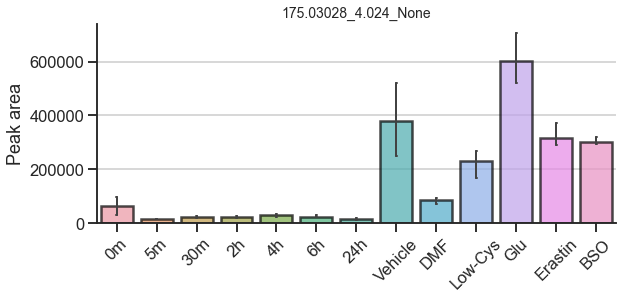

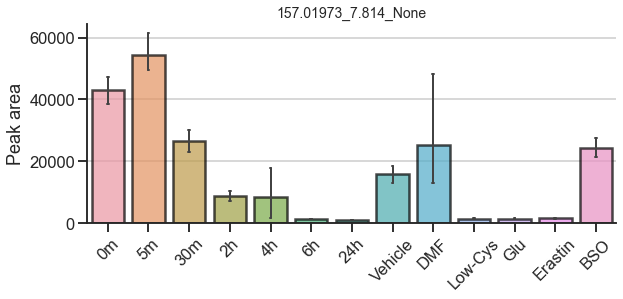

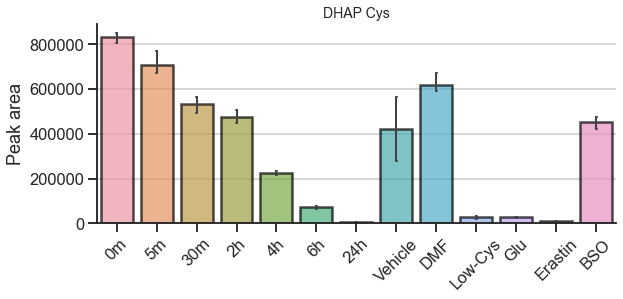

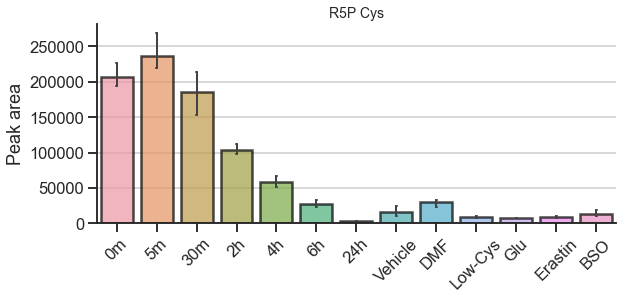

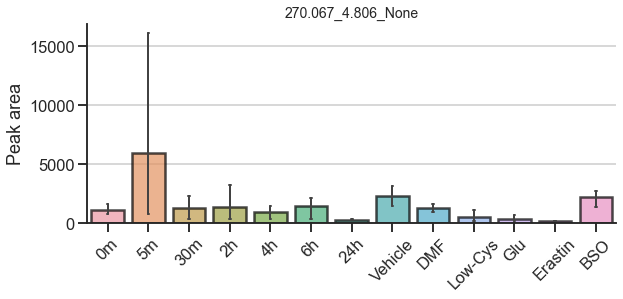

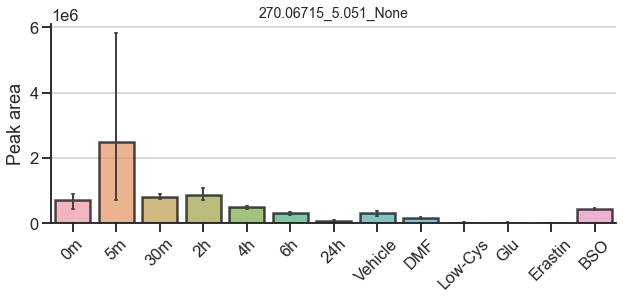

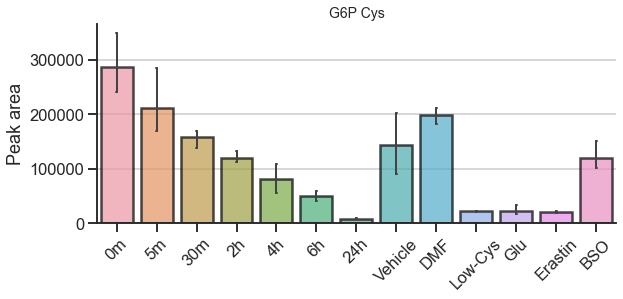

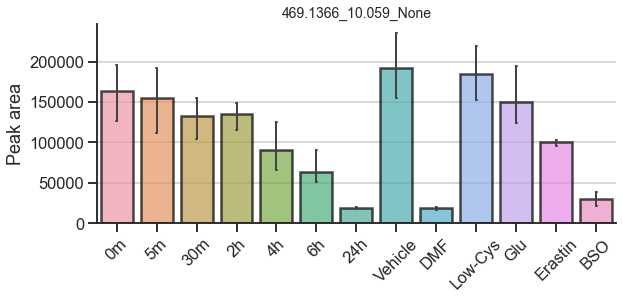

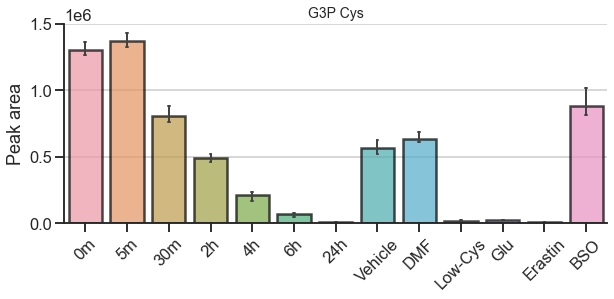

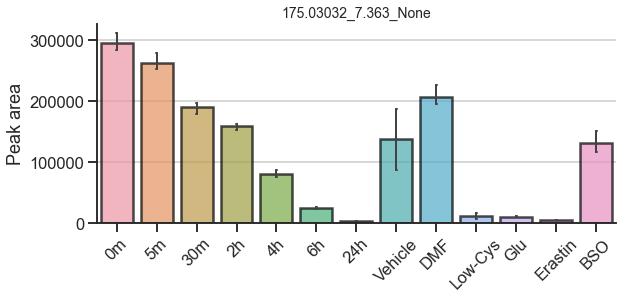

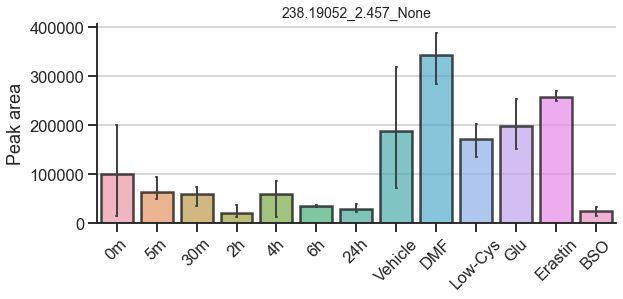

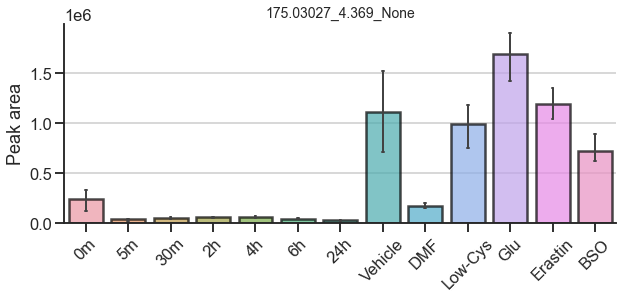

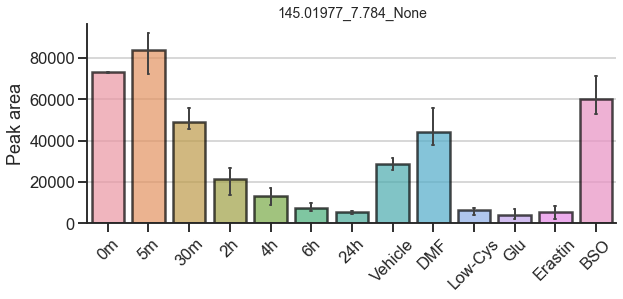

In [34]:
# Plotting, bile duct cells comparison (positive polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/pos/plots/SSP25_13C-Glc'
exclusion_set = {}
for peak_id in set(df_pos_flat['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    if name == 'None':
        name = peak_id
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 4.5))

    mask = (df_pos_flat['MW_RT_anno'] == peak_id) & (df_pos_flat['Cell_line'] == 'SSP25') & ~(df_pos_flat['Genotype'] == 'bile-duct-NRF2-on')
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=45)

    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

In [35]:
### Get plotting data in negative polarity ###
# Select peak pairs with more than 3 fold decrease after 24h 13C glucose labelling:
df_neg = peak_obj.label_pairs['cys']['neg']['peak_pair_area_parent'].copy()
t0 = df_neg.loc[:, ['SSP25_13C-Glc_0m_1', 'SSP25_13C-Glc_0m_2', 'SSP25_13C-Glc_0m_3']].sum(1)
t24 = df_neg.loc[:, ['SSP25_13C-Glc_24h_1', 'SSP25_13C-Glc_24h_2', 'SSP25_13C-Glc_24h_3']].sum(1)

mask = (t0/t24 > 3)
mask &= (df_neg['Isotopes'].isnull() & df_neg['Adducts'].isnull() & df_neg['Blacklist'].isnull()) | ~df_neg['known_anno'].isnull()
df_neg, df_neg_flat = flat_df(df_neg[mask], sample_info_df)

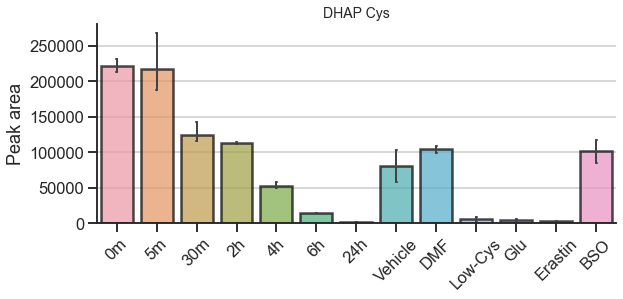

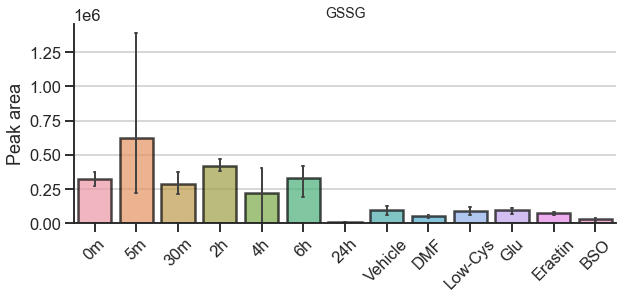

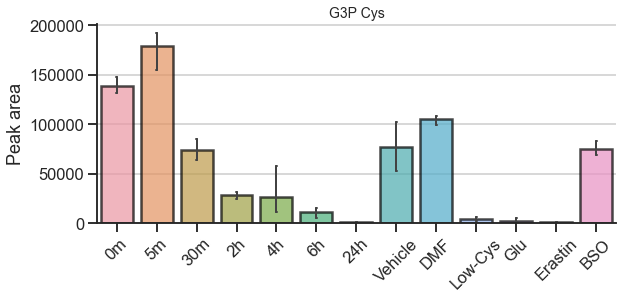

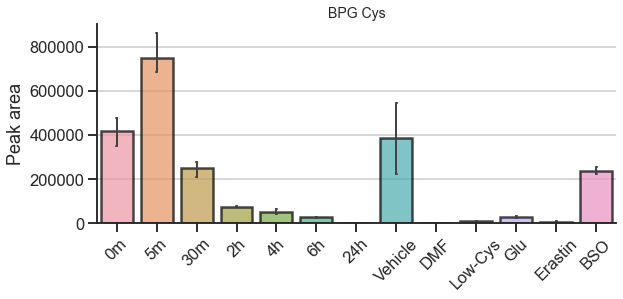

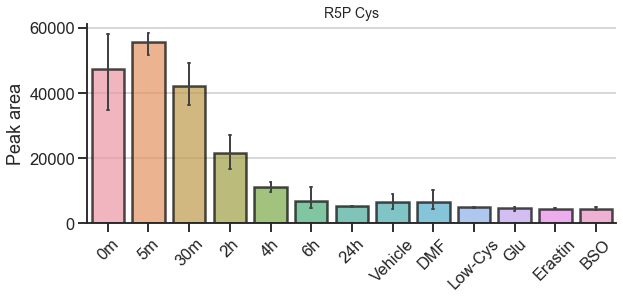

In [36]:
# Plotting, bile duct cells comparison (negative polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/neg/plots/SSP25_13C-Glc'
exclusion_set = {}
for peak_id in set(df_neg_flat['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    if name == 'None':
        name = peak_id
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 4.5))

    mask = (df_neg_flat['MW_RT_anno'] == peak_id) & (df_neg_flat['Cell_line'] == 'SSP25') & ~(df_neg_flat['Genotype'] == 'bile-duct-NRF2-on')
    g1 = sns.barplot(ax=ax1, data=df_neg_flat[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=45)

    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig